In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (29, 10)
plt.style.use('ggplot')
import seaborn as sns


from sklearn.model_selection import train_test_split


%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score

In [5]:
# Your goal is to accurately predict the likelihood that an individual has a bank account or not, i.e. Yes = 1, No = 0.

In [6]:
train_df = pd.read_csv('Train_v2.csv')
test_df = pd.read_csv('Test_v2.csv')
submission_df = pd.read_csv('SubmissionFile.csv')

In [7]:
train_df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [8]:
test_df.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [9]:
train_df.shape, test_df.shape

((23524, 13), (10086, 12))

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086 entries, 0 to 10085
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 10086 non-null  object
 1   year                    10086 non-null  int64 
 2   uniqueid                10086 non-null  object
 3   location_type           10086 non-null  object
 4   cellphone_access        10086 non-null  object
 5   household_size          10086 non-null  int64 
 6   age_of_respondent       10086 non-null  int64 
 7   gender_of_respondent    10086 non-null  object
 8   relationship_with_head  10086 non-null  object
 9   marital_status          10086 non-null  object
 10  education_level         10086 non-null  object
 11  job_type                10086 non-null  object
dtypes: int64(3), object(9)
memory usage: 945.7+ KB


In [12]:
# check for missing values in training set
train_df.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [13]:
# check for missing values in test set
test_df.isnull().sum()

country                   0
year                      0
uniqueid                  0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [14]:
# combine training and test set for easy preprocessing
ntrain = train_df.shape[0] # training set 
df_combined = pd.concat([train_df, test_df]).reset_index(drop=True)
df_combined.shape, ntrain

((33610, 13), 23524)

In [15]:
df_combined.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


**DATA PREPROCESSING**

In [16]:
# drop the uniqueid column
df_combined.drop(['uniqueid', 'year'], axis=1, inplace=True)

In [17]:
for i in df_combined.select_dtypes(include='object').columns:
  print('Column name: *{}* has *{}* unique values\n'.format(i, df_combined[i].nunique()))

Column name: *country* has *4* unique values

Column name: *bank_account* has *2* unique values

Column name: *location_type* has *2* unique values

Column name: *cellphone_access* has *2* unique values

Column name: *gender_of_respondent* has *2* unique values

Column name: *relationship_with_head* has *6* unique values

Column name: *marital_status* has *5* unique values

Column name: *education_level* has *6* unique values

Column name: *job_type* has *10* unique values



In [18]:
## Label Encoder(encode only values with 2 unique values; the rest will be done using ColumnTransformer later on the Notebook)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
df_combined['location_type'] = le.fit_transform(df_combined['location_type'])
df_combined['cellphone_access'] = le.fit_transform(df_combined['cellphone_access'])
df_combined['gender_of_respondent'] = le.fit_transform(df_combined['gender_of_respondent'])
df_combined['gender_of_respondent'] = le.fit_transform(df_combined['gender_of_respondent'])

In [19]:
df_combined

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,Yes,0,1,3,24,0,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,No,0,0,5,70,0,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,Yes,1,1,5,26,1,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,No,0,1,5,34,0,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,No,1,0,8,26,1,Child,Single/Never Married,Primary education,Informally employed
...,...,...,...,...,...,...,...,...,...,...,...
33605,Uganda,NaN,0,0,2,62,0,Spouse,Married/Living together,Primary education,Self employed
33606,Uganda,NaN,1,1,8,42,1,Head of Household,Married/Living together,Primary education,Self employed
33607,Uganda,NaN,1,1,1,39,1,Head of Household,Single/Never Married,Secondary education,Other Income
33608,Uganda,NaN,0,1,6,28,0,Spouse,Married/Living together,Primary education,Self employed


In [65]:
train_set = df_combined.iloc[:ntrain]
test_set = df_combined.iloc[ntrain:]

test_set_features = test_set.columns.difference(['bank_account']) # remove bank_account column from test_set
test_set = test_set[test_set_features]
test_set

,age_of_respondent,cellphone_access,country,education_level,gender_of_respondent,household_size,job_type,location_type,marital_status,relationship_with_head
23524,30,1,Kenya,Secondary education,1,3,Formally employed Government,1,Married/Living together,Head of Household
23525,51,1,Kenya,Vocational/Specialised training,1,7,Formally employed Private,1,Married/Living together,Head of Household
23526,77,0,Kenya,No formal education,0,3,Remittance Dependent,0,Married/Living together,Parent
23527,39,0,Kenya,Primary education,0,6,Remittance Dependent,0,Married/Living together,Head of Household
23528,16,0,Kenya,Secondary education,1,3,Remittance Dependent,1,Single/Never Married,Child
...,...,...,...,...,...,...,...,...,...,...
33605,62,0,Uganda,Primary education,0,2,Self employed,0,Married/Living together,Spouse
33606,42,1,Uganda,Primary education,1,8,Self employed,1,Married/Living together,Head of Household
33607,39,1,Uganda,Secondary education,1,1,Other Income,1,Single/Never Married,Head of Household
33608,28,1,Uganda,Primary education,0,6,Self employed,0,Married/Living together,Spouse


In [66]:
# Independent and Dependent variables
features = train_set.columns.difference(['bank_account'])
X = train_set[features].values
y = le.fit_transform(train_set['bank_account'].values)

**Encode Categorical Variables**





In [67]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9
0,24,1,Kenya,Secondary education,0,3,Self employed,0,Married/Living together,Spouse
1,70,0,Kenya,No formal education,0,5,Government Dependent,0,Widowed,Head of Household
2,26,1,Kenya,Vocational/Specialised training,1,5,Self employed,1,Single/Never Married,Other relative
3,34,1,Kenya,Primary education,0,5,Formally employed Private,0,Married/Living together,Head of Household
4,26,0,Kenya,Primary education,1,8,Informally employed,1,Single/Never Married,Child
...,...,...,...,...,...,...,...,...,...,...
23519,48,1,Uganda,No formal education,0,4,Other Income,0,Divorced/Seperated,Head of Household
23520,27,1,Uganda,Secondary education,0,2,Other Income,0,Single/Never Married,Head of Household
23521,27,1,Uganda,Primary education,0,5,Other Income,0,Widowed,Parent
23522,30,1,Uganda,Secondary education,0,7,Self employed,1,Divorced/Seperated,Parent


In [68]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(transformers=[
                                     ('encoder', OneHotEncoder(), [2, 3, 6, 8, 9])
], remainder='passthrough')
X = ct.fit_transform(X)
# Encode test set values for testing
test_set = ct.fit_transform(test_set.values)

**Split X into training set and test set**

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Perform Feature Scaling**

In [61]:
pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
X_train = pipeline.fit_transform(X_train.toarray())
X_test = pipeline.fit_transform(X_test.toarray())

In [62]:
from sklearn.model_selection import learning_curve
def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation,:]
    Y2 = Y[permutation]
    return X2, Y2

X2, y2 = randomize(X, y)

def draw_learning_curves(X, y, estimator, num_trainings):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X2, y2, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")


    plt.legend(loc="best")

    plt.show()

In [63]:
def run_model(classifier, xtrain, ytrain):
    
    
    classifier.fit(xtrain, ytrain)

    y_pred = classifier.predict(X_test)
    y_pred
    
    print("MODEL: ", classifier, "\n")
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm, "\n")
    
    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy Score: %s\n' %(accuracy * 100))
    
    # Cross Validation Score
    accuracies = cross_val_score(classifier, X=X_test, y=y_test, cv=10, scoring='accuracy')
    score = f1_score(y_test, y_pred)
    print("Cross Validation Accuracy: {:.2f}".format(accuracies.mean() * 100))
    print("STD: {:.2f}".format(accuracies.std() * 100))
    print("F1_Score: {}".format(score))
    
    draw_learning_curves(xtrain, ytrain, classifier, 12)

MODEL:  SVC(C=1, kernel='linear') 

[[3949  114]
 [ 481  161]] 

Accuracy Score: 87.35387885228481

Cross Validation Accuracy: 88.20
STD: 0.71
F1_Score: 0.3511450381679389


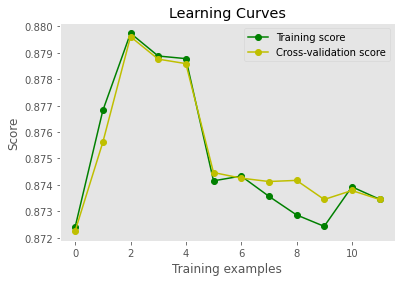

In [38]:
run_model(SVC(C=1, kernel='linear'), X_train, y_train) 

C:\Users\oneda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
MODEL:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 

[[3929  134]
 [ 395  247]] 

Accuracy Score: 88.75664187035069

[13:37:28] WARNING: C:/Users/Admin

C:\Users\oneda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

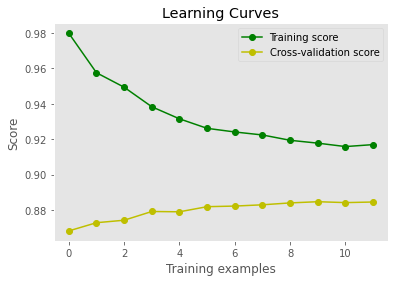

In [39]:
run_model(XGBClassifier(), X_train, y_train)

MODEL:  LogisticRegression() 

[[3943  120]
 [ 415  227]] 

Accuracy Score: 88.62911795961743

Cross Validation Accuracy: 88.74
STD: 0.44
F1_Score: 0.4590495449949444


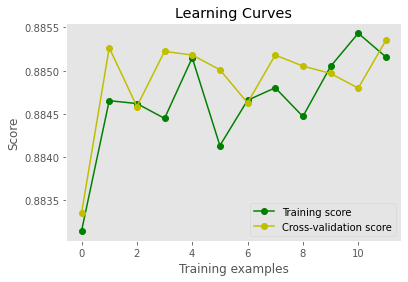

In [40]:
run_model(LogisticRegression(), X_train, y_train) 

MODEL:  DecisionTreeClassifier(criterion='entropy') 

[[3689  374]
 [ 383  259]] 

Accuracy Score: 83.91073326248672

Cross Validation Accuracy: 82.83
STD: 1.26
F1_Score: 0.4062745098039216


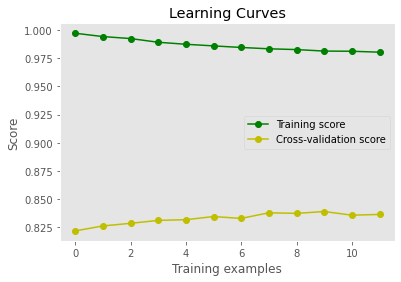

In [41]:
run_model(DecisionTreeClassifier(criterion='entropy'), X_train, y_train)

MODEL:  RandomForestClassifier(criterion='entropy', n_estimators=300) 

[[3794  269]
 [ 387  255]] 

Accuracy Score: 86.05738575982997

Cross Validation Accuracy: 87.50
STD: 1.27
F1_Score: 0.43739279588336194


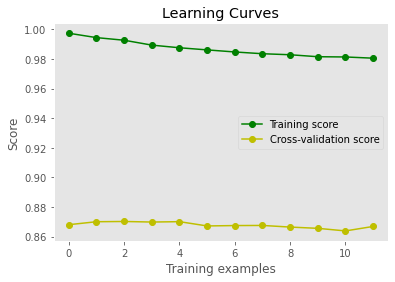

In [42]:
run_model(RandomForestClassifier(n_estimators=300, criterion='entropy'), X_train, y_train)

**Best Model: XGBClassifier**
    

In [48]:
from sklearn.model_selection import GridSearchCV
params = [{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
           'gamma': [0, 0.1, 0.2], 
           'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator=classifier, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

C:\Users\oneda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:17:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'gamma': 0, 'max_depth': 3, 'subsample': 0.6}

In [82]:
# fitting model with best parameters
classifier = XGBClassifier(max_depth=3, gamma=0, subsample=0.6)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

C:\Users\oneda\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [93]:
# check accuracy of new model
accuracy = accuracy_score(y_test, y_pred)
score = f1_score(y_test, y_pred)
print("New accuray score after parameter tuning is: {:.2f}".format(accuracy * 100))
print("F1_Score: {:.2f}".format(score))

New accuray score after parameter tuning is: 89.29
F1_Score: 0.49


**Predicting Testing Set results with provided test set**

In [69]:
# feature scale testing set values
test_set = pipeline.fit_transform(test_set.toarray())

In [94]:
y_pred_final = classifier.predict(test_set)

In [95]:
submission_df

,uniqueid,bank_account
0,uniqueid_7867 x Kenya,1.0
1,uniqueid_6722 x Kenya,0.0
2,uniqueid_6714 x Kenya,1.0
3,uniqueid_8103 x Kenya,1.0
4,uniqueid_8657 x Kenya,1.0
...,...,...
10081,uniqueid_2311 x Uganda,NaN
10082,uniqueid_2921 x Uganda,NaN
10083,uniqueid_2280 x Uganda,NaN
10084,uniqueid_2285 x Uganda,NaN


In [121]:
pd.DataFrame(data={'uniqueid': test_df['uniqueid'] + " x " + test_df['country'],
                  'bank_account': y_pred_final}).to_csv('final_submission.csv')

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0
...,...,...
10081,uniqueid_2998 x Uganda,0
10082,uniqueid_2999 x Uganda,0
10083,uniqueid_3000 x Uganda,0
10084,uniqueid_3001 x Uganda,0
